In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
# 데이터를 엑세스하기 위한 h5py
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import zipfile
import imageio
import os

# pytorch 패키지 다운
import torch
import torch.nn as nn
from torch.utils.data import Dataset


In [3]:
if torch.cuda.is_available():
   torch.set_default_tensor_type(torch.cuda.FloatTensor)
   print('using cuda:', torch.cuda.get_device_name(0))
   pass

using cuda: Tesla T4


In [4]:
# CelebA의 이미지 파일을 다운로드합니다
import torchvision.datasets
mnist_dataset = torchvision.datasets.CelebA(root='.', download=True)

RuntimeError: ignored

In [15]:
# 이미지를 2만장으로 추립니다.
%%time
hdf5_file = '/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py'
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('/content/celeba/img_align_celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass
     

images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
CPU times: user 2min 38s, sys: 12.2 s, total: 2min 51s
Wall time: 3min 31s


In [14]:
with h5py.File('/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py', 'r') as file_object:
   for group in file_object:
      print(group)
      pass

img_align_celeba


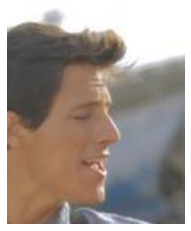

In [15]:
# 파일 하나만 꺼내보기 (2번)
with h5py.File('/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py', 'r') as file_object:
    dataset=file_object['img_align_celeba']
    image = np.array(dataset['2.jpg'])
    plt.imshow(image, interpolation = 'none')
    plt.axis('off')

In [16]:
class CelebADataset(Dataset):
     def __init__(self, file):
         self.file_object = h5py.File(file, 'r')
         self.dataset = self.file_object['img_align_celeba']
         pass
     def __len(self):
         return len(self.dataset)
     def __getitem__(self, index):
         if (index >= len(self.dataset)):
            raise IndexError()
         img = np.array(self.dataset[str(index)+'.jpg'])
         return torch.cuda.FloatTensor(img) / 255.0

     def plot_image(self, index):
         plt.imshow(np.array(self.dataset[str(index)+'.jpg']),
                    interpolation = 'nearest')
         pass
     pass 

In [26]:
x = generate_random_image(2)
print(x.device)
y = generate_random_seed(2)
print(y.device)

cuda:0
cuda:0


In [17]:
celeba_dataset = CelebADataset('/content/mount/My Drive/Colab Notebooks/celeba_aligned_small.h5py')

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [24]:
# 판별자

class View(nn.Module):
   def __init__(self, shape):
       super().__init__()
       self.shape = shape,

   def forward(self, x):
       return x.view(*self.shape)

class Discriminator(nn.Module):
   def __init__(self):
       super().__init__()
       self.model = nn.Sequential(
           View(218*178*3),
           nn.Linear(3*218*178,100),
           nn.LeakyReLU(),
           nn.LayerNorm(100),
           nn.Linear(100,1),
           nn.Sigmoid()
       )
       self.loss_function = nn.MSELoss()
       self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)
       self.counter = 0;
       self.progress = []

   def forward(self, inputs):
        return self.model(inputs)
    
    
   def train(self, inputs, targets):
       outputs = self.forward(inputs)
        
       loss = self.loss_function(outputs, targets)

       self.counter += 1;
       if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
       if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass


       self.optimiser.zero_grad()
       loss.backward()
       self.optimiser.step()

       pass
    
    
   def plot_progress(self):
       df = pd.DataFrame(self.progress, columns=['loss'])
       df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
       pass
    
   pass

In [27]:
# discriminator 시간 체크

%%time
D = Discriminator()
D.to(device)
for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 2min 12s, sys: 3.34 s, total: 2min 15s
Wall time: 2min 31s


In [54]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [57]:
G = Generator()
G.to(device)


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=300, out_features=116412, bias=True)
    (4): Sigmoid()
    (5): View()
  )
)

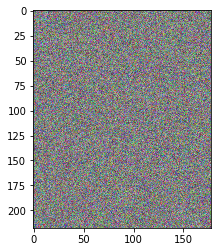

In [58]:
output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap = 'Reds')

In [48]:
%%time

EPOCHS = 10

for epoch in range(1, EPOCHS):
    print(f' 에포크 = {epoch}')

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
    pass
pass    

 에포크 = 1
 에포크 = 2
 에포크 = 3
 에포크 = 4
 에포크 = 5
 에포크 = 6
 에포크 = 7
 에포크 = 8
 에포크 = 9
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counter =  60000
counter =  61000
counter =  62000
counter =  63000
counter =  64000
counter =  65000
counter =  66000
counter =  67000
counter =  68000
counter =  69000
counter =  70000
counter =  71000
counter =  72000
counter =  73000
counter =  74000
counter =  75000
counter =  76000
counter =  77000
counter =  78000
counter =  79000
counter =  80000
counter =  81000
counter =  82000
counter =  83000
CPU times: user 8min 36s, sys: 4.65 s, total: 8min 40s
Wall time: 8min 41s


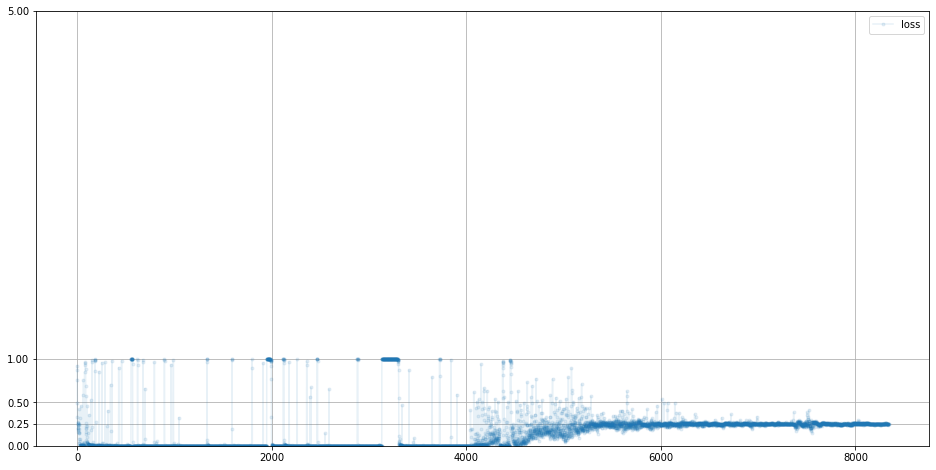

In [49]:
D.plot_progress()

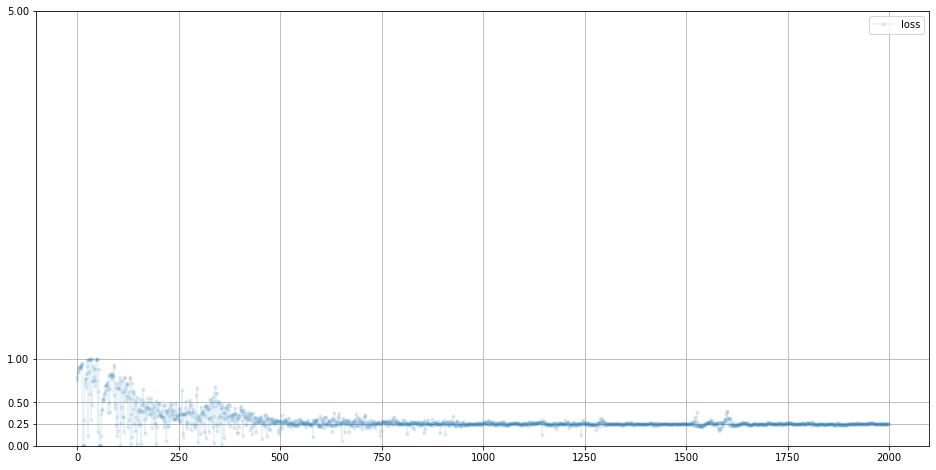

In [50]:
G.plot_progress()

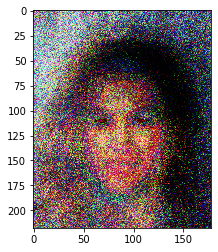

In [56]:
plt.imshow(img, interpolation='none', cmap = 'Reds')